In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import gymnasium as gym
import numpy as np
from envs.dubins_car import DubinsCarEnv


import jax
import jax.numpy as jnp
import haiku as hk
import optax

In [2]:
jax.default_backend()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


'cpu'

In [85]:
x_s = np.linspace(-4,4, 15)
y_s = np.linspace(-4,4, 15)
theta_s = np.linspace(0,2*np.pi, 15)


In [86]:
xx, yy, tt = np.meshgrid(x_s, y_s, theta_s)

In [87]:
grid = np.vstack([xx.ravel(), yy.ravel(), tt.ravel()]).T
len(grid)

3375

In [88]:
grid

array([[-4.        , -4.        ,  0.        ],
       [-4.        , -4.        ,  0.44879895],
       [-4.        , -4.        ,  0.8975979 ],
       ...,
       [ 4.        ,  4.        ,  5.38558741],
       [ 4.        ,  4.        ,  5.83438636],
       [ 4.        ,  4.        ,  6.28318531]])

In [2]:
#generate data

env = DubinsCarEnv()
state = env.reset()
X = []
y = []
for i in range(len(grid)):
    state = env.set(grid[i][0], grid[i][1], grid[i][2])
    for action in range(env.action_space.n):
        X.append(state)
        r = env.sample(state, action, 0)
        y.append(r)

X = np.array(X)
y = np.array(y)



/ifs/CS/replicated/home/apraka15/Desktop/Projects/Reach-Avoid/gym-examples/.env/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


NameError: name 'grid' is not defined

In [54]:
env = DubinsCarEnv()
state = env.reset()
X = []
y = []
for i in range(500):
    state = env.reset()
    X.append(state)
    for action in range(env.action_space.n):
        next_state, reward, done, _ = env.step(state, action, update_env=False)
        X.append(next_state)


X = np.array(X)


/ifs/CS/replicated/home/apraka15/Desktop/Projects/Reach-Avoid/gym-examples/.env/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


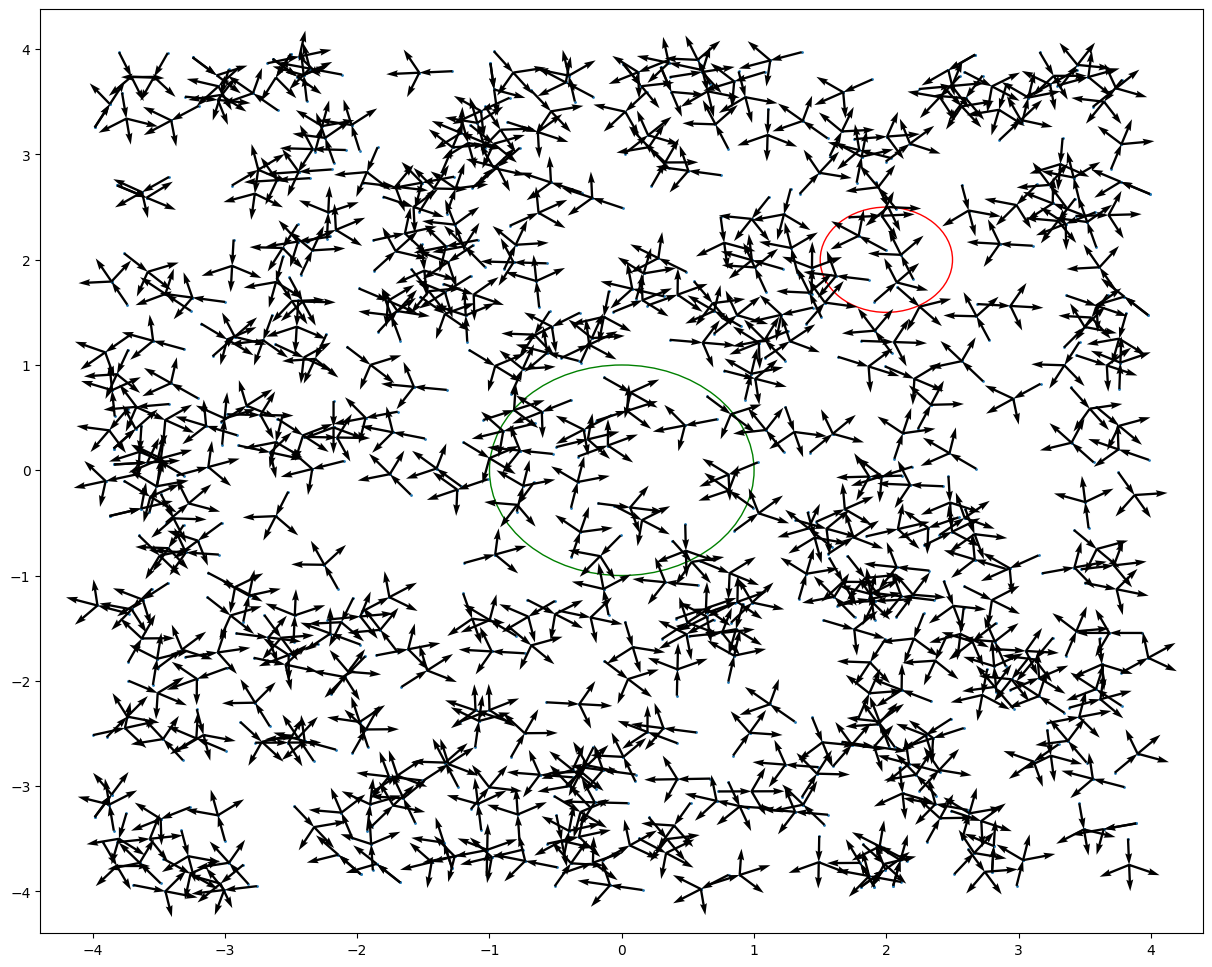

In [55]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 12]

# Plot...
plt.scatter(X[:,0], X[:,1], s=1) # s is a size of marker 
        # draw goal
goal = plt.Circle((env.goal_position[0], env.goal_position[1]), env.min_distance_to_goal, color='g', fill=False)

# draw obstacle
obstacle = plt.Circle((env.obstacle_position[0], env.obstacle_position[1]), env.obstacle_radius, color='r', fill=False)
plt.gca().add_artist(obstacle)
plt.gca().add_artist(goal)


arrow_len = env.v_max
# Calculate arrow components
arrow_dx = arrow_len * np.cos(X[:,2])
arrow_dy = arrow_len * np.sin(X[:,2])
plt.quiver(X[:,0], X[:,1], arrow_dx, arrow_dy, angles='xy', scale_units='xy', scale=1, width=0.002, color='k')


plt.jet()
#plt.show()
plt.savefig('env.png')

In [62]:
X

array([[ 1.78843   , -2.3544383 ,  0.33245206,  0.9431202 ],
       [ 1.8715429 , -2.1186583 ,  0.99525744,  0.09727594],
       [ 1.8715429 , -2.1186583 ,  0.33245206,  0.9431202 ],
       ...,
       [-3.4929998 , -0.81079185, -0.43104672, -0.9023296 ],
       [-3.4929998 , -0.81079185,  0.63561994, -0.7720021 ],
       [-3.4929998 , -0.81079185,  0.9682962 ,  0.24980491]],
      dtype=float32)

In [60]:
X = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X)))
X


array([[ 1.78843   , -2.3544383 ,  0.33245206,  0.9431202 ],
       [ 1.8715429 , -2.1186583 ,  0.99525744,  0.09727594],
       [ 1.8715429 , -2.1186583 ,  0.33245206,  0.9431202 ],
       ...,
       [-3.4929998 , -0.81079185, -0.43104672, -0.9023296 ],
       [-3.4929998 , -0.81079185,  0.63561994, -0.7720021 ],
       [-3.4929998 , -0.81079185,  0.9682962 ,  0.24980491]],
      dtype=float32)

In [61]:
#params are defined *implicitly* in haiku
def forward(X):
    l1 = hk.Linear(8)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(1)(l2)

    return l3.ravel()


#params are defined *implicitly* in haiku
# def forward(X):
#     l1 = hk.Linear(12)(X)
#     l2 = jax.nn.relu(l1)
#     l3 = hk.Linear(6)(l2)
#     l4 = jax.nn.relu(l3)

#     l5= hk.Linear(1)(l4)

#     return l5
# def forward(X):

#     mlp = hk.nets.MLP(output_sizes=[3,1])
#     return mlp(X)

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    return jnp.mean(jnp.square(err))  # mse



optimizer = optax.adabelief(learning_rate=1e-1)
opt_state = optimizer.init(params)
batch_size = 50 #make it 200-50
losses = []
#check we aren't double using gradients
opt_state = optimizer.init(params)
for epoch in range(500):
    batch_loss = []
    for batch in range(0,len(X), batch_size):
        X_batch = X[batch:batch+batch_size]
        y_batch = env.sample_value_iter(X_batch, forward, params, gamma=0.8)
    
        loss, grads = jax.value_and_grad(loss_fn)(params,X=X_batch,y=y_batch)
        #print("progress:", "epoch:", epoch, "batch loss",loss)
        batch_loss.append(loss)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
    losses.append(np.mean(batch_loss))
    print('epoch', epoch, 'average loss', np.mean(batch_loss))
        
    
    
# After training
print("estimation of the parameters:")
print(params)

estimate  = forward(X=env.reset(), params=params)
print("estimate", estimate)

epoch 0 average loss 5.4758544
epoch 1 average loss 3.452607
epoch 2 average loss 2.7666876
epoch 3 average loss 1.9323515
epoch 4 average loss 1.8599498
epoch 5 average loss 2.1410382
epoch 6 average loss 1.8086193
epoch 7 average loss 1.8529564
epoch 8 average loss 1.4526802
epoch 9 average loss 1.7839749
epoch 10 average loss 1.5552067
epoch 11 average loss 1.6480557
epoch 12 average loss 1.5378411
epoch 13 average loss 1.686647
epoch 14 average loss 1.6013155
epoch 15 average loss 1.7654693
epoch 16 average loss 1.6068522
epoch 17 average loss 1.6334223
epoch 18 average loss 1.5319313
epoch 19 average loss 1.71954
epoch 20 average loss 1.5764359
epoch 21 average loss 1.6907203
epoch 22 average loss 1.6066166
epoch 23 average loss 1.926286
epoch 24 average loss 1.6342022
epoch 25 average loss 1.640755
epoch 26 average loss 1.6019642
epoch 27 average loss 1.6824634
epoch 28 average loss 1.6330725
epoch 29 average loss 1.6586916
epoch 30 average loss 1.6773803
epoch 31 average loss 1.

ValueError: 'linear/w' with retrieved shape (4, 8) does not match shape=[3, 8] dtype=dtype('float32')

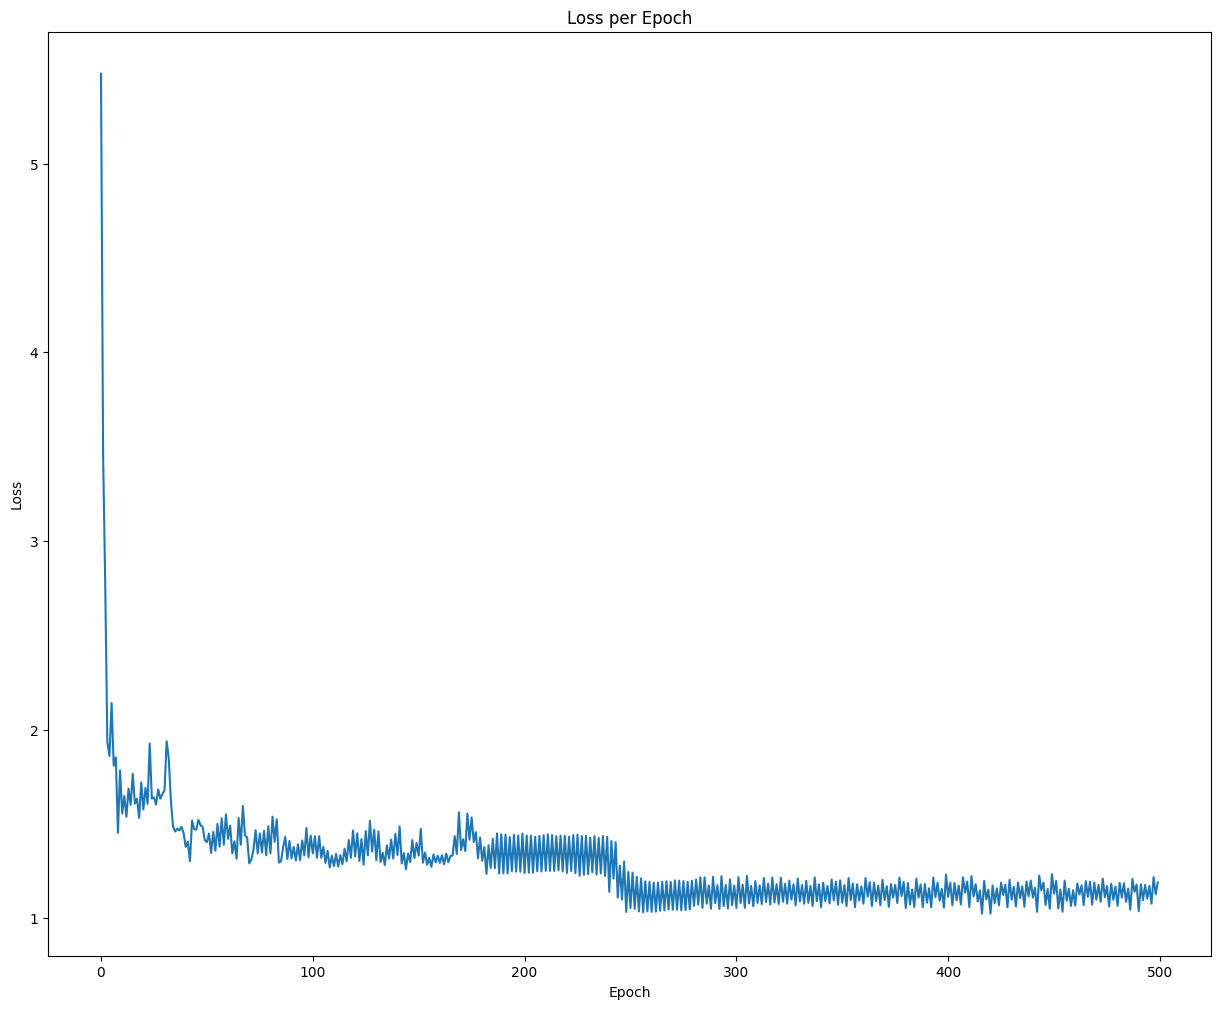

In [63]:
# Plot the losses
lo = [l.item() for l in losses]

plt.plot(lo)

# Add a title and labels to the x and y axis
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Show the plot
plt.savefig('losses.png')

plt.show()

In [12]:
env = DubinsCarEnv()
state = env.reset()
X_val = []
for i in range(1000):
    state = env.reset()
    X_val.append(state)
    for action in range(env.action_space.n):
        next_state, reward, done, _ = env.step(state, action, update_env=False)
        X_val.append(next_state)


X_val = np.array(X_val)
X_val_encoded = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X_val)))


/ifs/CS/replicated/home/apraka15/Desktop/Projects/Reach-Avoid/gym-examples/.env/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [64]:
y_pred = [forward(X=x, params=params) for x in X_val_encoded]

In [30]:
max(y_pred)

Array([1.2129371], dtype=float32)

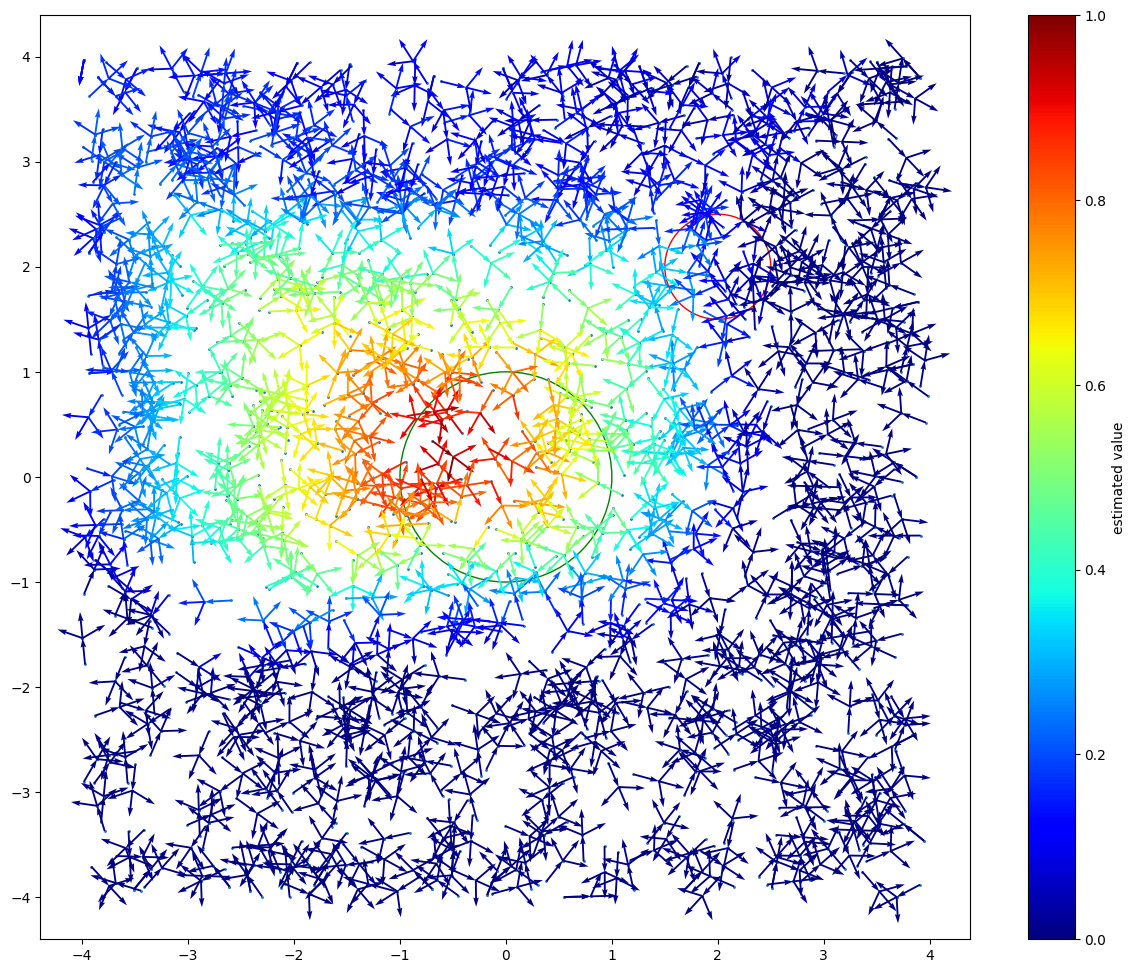

In [65]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm


# Plot...
plt.scatter(X_val[:,0], X_val[:,1], s=1) # s is a size of marker 
plt.jet()
plt.colorbar(label='estimated value')
#plt.savefig('500_iter_adabeleif_.85gamma.png')
#plt.show()

#draw goal
goal = plt.Circle((env.goal_position[0], env.goal_position[1]), env.min_distance_to_goal, color='g', fill=False)

# draw obstacle
obstacle = plt.Circle((env.obstacle_position[0], env.obstacle_position[1]), env.obstacle_radius, color='r', fill=False)
plt.gca().add_artist(obstacle)
plt.gca().add_artist(goal)


arrow_len = env.v_max
# Calculate arrow components
arrow_dx = arrow_len * np.cos(X_val[:,2])
arrow_dy = arrow_len * np.sin(X_val[:,2])

arrow_colors = cm.jet(y_pred/np.max(y_pred))


plt.quiver(X_val[:,0], X_val[:,1], arrow_dx, arrow_dy, angles='xy', scale_units='xy', scale=1, width=0.002, color=arrow_colors)


plt.jet()

In [71]:
#train on small steps, run on bigger steps?
right = 0
up = np.pi / 2
down = 3 * np.pi / 2
left = np.pi

env = DubinsCarEnv()
#state = env.set(-3, -2, right)
state = env.reset()

gamma = 0.85
traj = []
done = False
max_iter = 50
counter = 0
while (not done) and (counter < max_iter):
    counter+=1
    possible_actions = []
    for a in range(env.action_space.n):
        next_state, reward, done, _ = env.step(state, a, update_env=False)
        #estimate = forward(X=next_state, params=params)
        estimate = forward(X=np.array([next_state[0], next_state[1], np.cos(next_state[2]), np.sin(next_state[2])]), params=params)

        value = reward + gamma*estimate[0]
        print('estimate', value)
        print('state:',next_state)

        possible_actions.append(value)

    action = np.argmax(np.array(possible_actions))
    print('next_states', action, possible_actions)
    traj.append(state)
    state, reward, done, _ = env.step(action=action, update_env=True)
    env.render()
    print(counter)
    
env.make_gif()

estimate -2.3626907
state: [ 0.82570475 -2.8847575   2.2764354 ]
estimate -2.751047
state: [ 0.82570475 -2.8847575   3.4108994 ]
estimate -2.9940217
state: [ 0.82570475 -2.8847575   4.5453634 ]
next_states 0 [Array(-2.3626907, dtype=float32), Array(-2.751047, dtype=float32), Array(-2.9940217, dtype=float32)]
1
estimate -1.8171246
state: [ 0.66357464 -2.6944582   1.1419713 ]
estimate -1.9024025
state: [ 0.66357464 -2.6944582   2.2764354 ]
estimate -2.2907586
state: [ 0.66357464 -2.6944582   3.4108994 ]
next_states 0 [Array(-1.8171246, dtype=float32), Array(-1.9024025, dtype=float32), Array(-2.2907586, dtype=float32)]
2
estimate -1.6309682
state: [ 0.76752526 -2.4670944   0.00750734]
estimate -1.314693
state: [ 0.76752526 -2.4670944   1.1419713 ]
estimate -1.399971
state: [ 0.76752526 -2.4670944   2.2764354 ]
next_states 1 [Array(-1.6309682, dtype=float32), Array(-1.314693, dtype=float32), Array(-1.399971, dtype=float32)]
3
estimate -1.1285366
state: [ 0.8714759  -2.2397306   0.00750734]

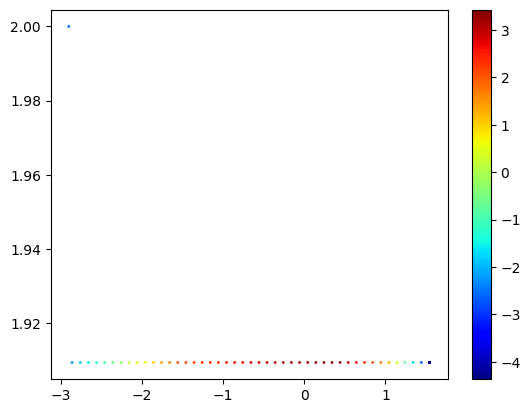

In [51]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
t = np.array([traj])
yp = [forward(X=x, params=params) for x in t]

# Plot...
plt.scatter(np.array(traj)[:,0], np.array(traj)[:,1], c=yp, s=1) # s is a size of marker 
plt.jet()
plt.colorbar()
plt.show()
#plt.savefig('500_iter.png')

In [25]:
value

Array(-15.296058, dtype=float32)

In [689]:
forward(X=np.array([0,0,0]), params=params) 

Array([0.23673654], dtype=float32)

In [ ]:
#plot with arrows and try without obstacle. 